# NLP Exploration
What exactly is the goal of this exploration? 
* we have a set of domain names that currently aren't being utilized at all
* if we segment out the specific words and try to perform something similar to a sentiment analysis, we may be able to extract a stronger signal and lead to a higher classification rate

# NLP Terminology
* **Corpus**: Collection of text
* **Tokens**: Words and punctuation that make up the corpus. 
* **Type**: a distinct token. Ex. "Run, Lola Run" has four tokens (comma counts as one) and 3 types.
* **Vocabulary**: The set of all types. 
* The google corpus (collection of text) has 1 trillion tokens, and only 13 million types. English only has 1 million dictionary words, but the google corpus includes types such as "www.facebook.com". 

### Things to consider:
* will want to preprocess: parse off the .com, 
* may want to get rid of any numbers 
* may also want to consider removing the number from the string, but having a boolean "domain_name_contains_number" set to true or false

### Things to note:
* this is preliminary and is just the first step in this process

---
# Test 1 - Implement domain value analysis using NLP
This is going to be a basic implementation that only looks at the domain name- it does not include other features such as domain age, private regisration status, etc. 

In [157]:
# standard
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [158]:
analystScoredDomains = pd.read_csv('PPSDomains.csv')

In [159]:
analystScoredDomains.head()

,domain,analystResult,BellonaStatus,medianLoadTime,speedPercentile,trafficDataRank,trafficDataReachRank,reachPerMillionValue,pageViewsPerMillionValue,pageViewsRankValue,usageStatisticRankValue,reachRankValue,historyDataScore,domainAge,registrantContactCountry,privateRegistrationStatus
0,07449m.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,68.0,UNITED STATES,"{""registrantName"":""Domain Administrator"",""simi..."
1,1037kissfm.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,6955.0,UNITED STATES,NaN
2,1041kqth.com,NaN,TODO,7687.0,1.0,1941173.0,1872730.0,0.2,0.01,2322074.0,2025813.0,2060156.0,3,1251.0,UNITED STATES,NaN
3,1049maxcountry.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,978.0,UNITED STATES,NaN
4,1053thebuzz.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,6221.0,UNITED STATES,NaN


In [160]:
# preprocess
# get rid of unecessary features
analystScoredDomains = analystScoredDomains.drop(['historyDataScore', 'medianLoadTime','speedPercentile', 'trafficDataReachRank', 
                        'reachPerMillionValue', 'pageViewsRankValue','pageViewsPerMillionValue', 
                        'usageStatisticRankValue', 'reachRankValue', 'BellonaStatus', 'trafficDataRank'], axis=1)

# get rid of unlabeled examples
analystScoredDomains = analystScoredDomains[pd.notnull(analystScoredDomains['analystResult'])] 

# map private registration status 
analystScoredDomains['privateRegistrationStatus'] = analystScoredDomains['privateRegistrationStatus'].replace(np.nan, 0)
analystScoredDomains['privateRegistrationStatus'] = analystScoredDomains['privateRegistrationStatus'].map(lambda x: 1 if x != 0 else 0)

# map registrant contact country
analystScoredDomains['registrantContactCountry'] = analystScoredDomains['registrantContactCountry'].map(lambda x: 1 if x == 'UNITED STATES' else 0)

# normalize domain age
# analystScoredDomains['domainAge'] = (analystScoredDomains['domainAge'] - analystScoredDomains['domainAge'].mean())/(analystScoredDomains['domainAge'].std())

# map analyst result to 0 or 1 
analystScoredDomains = analystScoredDomains[pd.notnull(analystScoredDomains['analystResult'])] 
ar = {'TRUE': 1, 'FALSE': 0, 'TRUE ': 1, 'FALSE ': 0}
analystScoredDomains['analystResult'] = analystScoredDomains['analystResult'].map(ar)

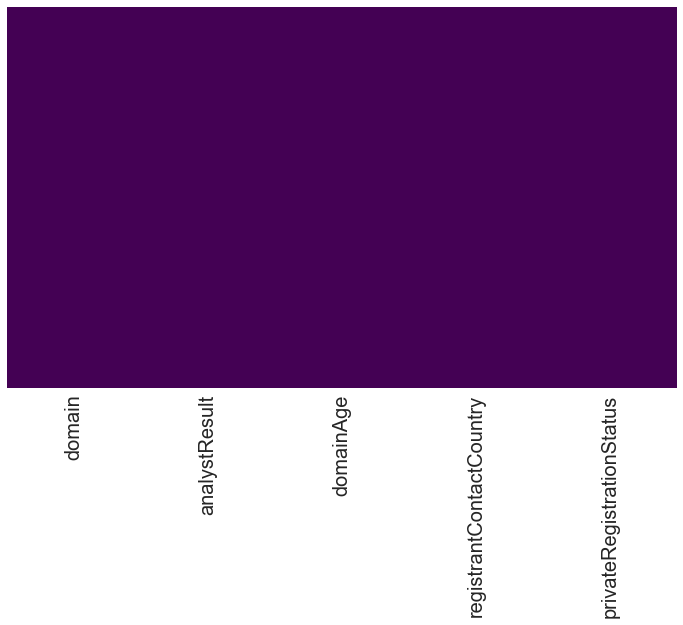

In [161]:
plt.figure(figsize=(12,7))
sns.set(font_scale=2)
sns.heatmap(analystScoredDomains.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [162]:
analystScoredDomains.head()

,domain,analystResult,domainAge,registrantContactCountry,privateRegistrationStatus
10,10thousandcouples.com,0,3060.0,0,0
11,1170kfaq.com,0,5566.0,1,0
12,11alive.com,0,7376.0,1,0
13,120gdyiyuan.com,0,9.0,1,0
14,12news.com,0,7122.0,1,0


### Start with our imports

In [163]:
import nltk
from nltk.stem import WordNetLemmatizer
from wordsegment import load, segment, UNIGRAMS
load() 

When we import segment and UNIGRAMS we gain access to the segment method:
> `segment('10thousandcouples.com') -> ['10', 'thousand', 'couples', 'com']`

And the UNIGRAMS method:
> `UNIGRAMS['hi'] // 67566273.0`

In [164]:
UNIGRAMS['rad'] > UNIGRAMS['radar']

False

In [165]:
UNIGRAMS['digital']

202346767.0

In [166]:
UNIGRAMS['dig']

7292787.0

### Class imbalance
There are more valuable than non-valuable domains in our dataset, so we are going to shuffle the positive domains and then cut off any extra that we may have so that they are both the same size.

In [167]:
from sklearn.utils import shuffle

# get valuable domains and then shuffle them
valuableDomains = analystScoredDomains[analystScoredDomains['analystResult'] == 1]
valuableDomains = shuffle(valuableDomains)

# get non valuable domains 
nonValuableDomains = analystScoredDomains[analystScoredDomains['analystResult'] == 0]

# cut off any extra valuable domains so that there are the same number as non valuable domains
valuableDomains = valuableDomains[:nonValuableDomains.shape[0]]

# assert to make sure that the valuable and nonvaluable domains are now the same size
assert(nonValuableDomains.shape == valuableDomains.shape)

### Tokenizer Function
Lets now create a tokenizer function that can be used on our specific reviews. 

In [168]:
wordnet_lemmatizer = WordNetLemmatizer()                           # this turns words into their base form 
stopwords = set(w.rstrip() for w in open('stopwords.txt'))         # grab stop words 

def custom_tokenizer(s):
    s = s.lower()
    s = s.split('.')[0]                                            # split at . and remove .com
    tokens = segment(s)                                            # essentially string.split()
    tokens = [t for t in tokens if len(t) > 2]                     # get rid of short words
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]     # get words to base form
    tokens = [t for t in tokens if t not in stopwords]
    return tokens

### Index each word
Okay, now we need to create an index for each of the words, so that each word has an index in the final data vector. However, to be able to do that we need to know the size of the final data vector, and to be able to do that we need to know how big the vocabulary is. 

Remember, the **vocabulary** is just the set of all **types**. In other words, we need a list of all the words that are included in the domains, and no word in the list can repeat. 

To do this we will look at every individual domain name, tokenize each one, and then add those tokens 1 by 1 to the map if they do not exist yet. 

In [169]:
word_index_map = {}                        # our vocabulary - dictionary that will map words to dictionaries 
current_index = 0                          # counter increases whenever we see a new word 

valuable_tokenized = []
nonValuable_tokenized = []

# ----------- loop through the valuable domains ----------
for domain in valuableDomains['domain'].tolist():
    tokens = custom_tokenizer(domain)                  # converts single domain name into array of tokens 
    valuable_tokenized.append(tokens)
    for token in tokens:                               # loops through array of tokens for specific domain name
        if token not in word_index_map:                                  # if the token is not in the map, add it 
            word_index_map[token] = current_index
            current_index +=1                                            # increment the current index

# ----------- loop through the nonvaluable domains ----------
for domain in nonValuableDomains['domain'].tolist():
    tokens = custom_tokenizer(domain)
    nonValuable_tokenized.append(tokens)
    for token in tokens:
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index +=1

At this point our word index map has been created, lets take a look at our vocabulary size.

In [170]:
print('Vocabulary size: ', len(word_index_map))

('Vocabulary size: ', 1780)


And lets look at 40 selected entries from the map of our vocabulary.

In [171]:
vocabulary = list(word_index_map)
np.random.shuffle(vocabulary)
print('40 randomly selected terms from vocabulary:\n\n' , vocabulary[:40])

('40 randomly selected terms from vocabulary:\n\n', ['ameb', 'dik', 'vote', 'boombox', 'lorenzo', 'pocket', 'chronicle', 'platinum', 'sun', '937', 'mold', 'photography', 'share', 'biggies', 'crab', 'pro', 'patrick', 'hyper', 'conservative', 'keh', 'pening', '921', 'twitter', 'sit', 'beloit', 'kurv', 'elle', 'xii', 'advocate', 'cin', 'sizzle', 'zimmermann', 'kion546', 'frontiersman', 'superficial', 'spagnola', 'ram', 'kiss985', 'foreign', 'espn'])


We can clearly see that some of these words are not ideal, or even words, but we will worry about reducing features going forward. 

At this point we have an additional ~1786 input features, each corresponding to a word from our vocabulary. The goal at this point is to find several words that have a high correlation to a valuable domain name. 

### Convert tokens into Vector
So, we have our tokens, and our vocabulary. We now need to convert our tokens into a vector. Because we are going to shuffle our train and test sets again, we are going to want to put labels and the vector into the same array for now, since it makes it easier to shuffle.

Note: this function operates on **one** review. The +1 is creating our label, and this function is designed to take our input vector from an english form and convert it to a numeric vector form. 

In [172]:
def tokens_to_vector(tokens, label):
    xy_data = np.zeros(len(word_index_map) + 1)           # this is equal to the vocab size +1 for the label
    for t in tokens:                                      # loop through every token
        i = word_index_map[t]                             # get index from word index map
        xy_data[i] += 1                                   # increment data at that index
    xy_data = xy_data / xy_data.sum()                     # divide entire array by total, so they add up to 1
    xy_data[-1] = label                                   # set last element to label
    return xy_data

Lets now actually assign these tokens to vectors. 

In [173]:
N = len(valuable_tokenized) + len(nonValuable_tokenized)            # this is the total number of training domains
data = np.zeros((N, len(word_index_map) + 1))                       # N examples x vocab size + 1 for label
i = 0                                                               # counter to keep track of samples

for tokens in valuable_tokenized:                                   # loop through valuable tokenized domains
    if tokens == []:
        continue
    xy = tokens_to_vector(tokens, 1)                                # passing in 1 b/c these are valuable domains
    data[i,:] = xy                                                  # set data row to that of the input vector
    i += 1                                                          # increment 1


for tokens in nonValuable_tokenized:   
    if tokens == []:
        continue
    xy = tokens_to_vector(tokens, 0)                                
    data[i,:] = xy                                                 
    i += 1    

### Train our Model
Now that we have our data in the correct format, we can train our model. 

In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
model = LogisticRegression()
np.random.shuffle(data)
np.nan_to_num(data)
X = data[:, :-1]
Y = data[:, -1]

Xtrain = X[:-100,]
Ytrain = Y[:-100,]
Xtest = X[-100:,]
Ytest = Y[-100:,]


model = LogisticRegression()
model.fit(Xtrain, Ytrain)
print("Classification Rate: ", model.score(Xtest, Ytest))

('Classification Rate: ', 0.57)


### Sentiment Analysis
Something interesting that we can do is look at the weights of each word, to see if that word has positive or negative sentiment. 

In [175]:
threshold = 0.9
sa_dict = {}
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > threshold or weight < -threshold:
        sa_dict[word] = weight
        print(word, weight )
sa_dict

('radio', 2.0621692295479357)
('blog', -1.0334895752004654)
('celebrity', -1.0377234432715117)
('nbc', 1.4814098639231104)
('local', 0.920295130572336)
('telemundo', 1.727611446266371)


{'blog': -1.0334895752004654,
 'celebrity': -1.0377234432715117,
 'local': 0.920295130572336,
 'nbc': 1.4814098639231104,
 'radio': 2.0621692295479357,
 'telemundo': 1.727611446266371}

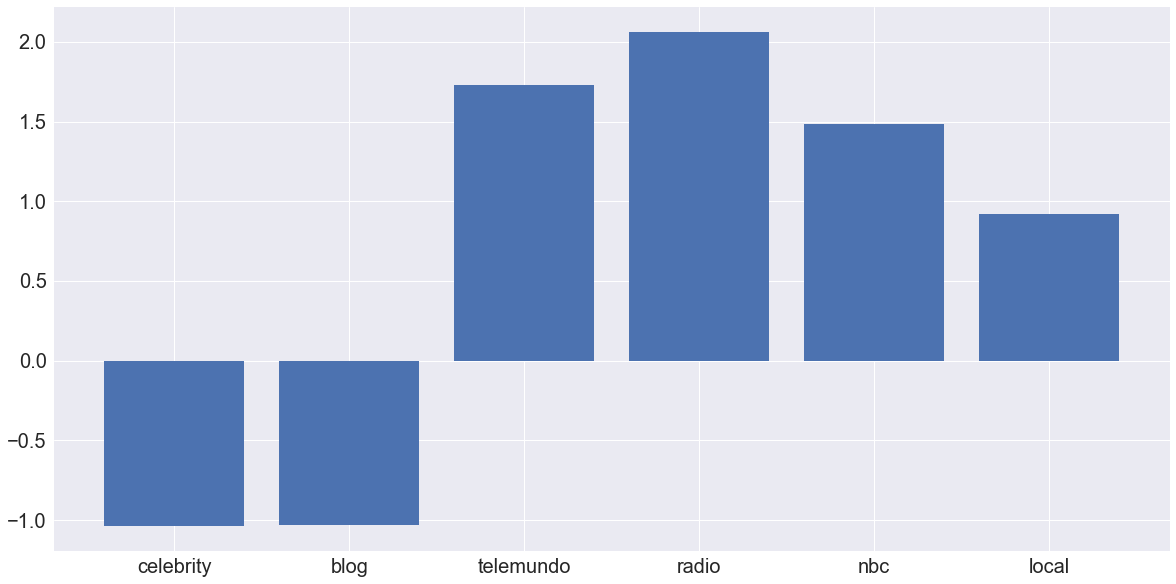

In [176]:
plt.figure(figsize=(20,10))
plt.bar(range(len(sa_dict)), list(sa_dict.values()), align='center')
plt.xticks(range(len(sa_dict)), list(sa_dict.keys()))
plt.show()

---
# Test 2 - Combing NLP input with prior input features

Lets repeat the process above, only this time the entire process will be conducted on the data frame of all the training examples.

### Combine valuable and nonvaluable domains
We are going to start by combining the valuable and nonvaluable domains. After that we are going to create a new empty column that will hold the tokenizer domains. 

In [101]:
balancedDomains = pd.concat([valuableDomains, nonValuableDomains])
balancedDomains['tokenized_domain'] = ''
balancedDomains.head()

,domain,analystResult,domainAge,registrantContactCountry,privateRegistrationStatus,tokenized_domain
1520,radiomixbrazil.com,1,683.0,1,1,
1195,motherjones.com,1,7726.0,1,1,
661,fox47.com,1,7909.0,1,0,
1218,myajc.com,1,5294.0,1,1,
1956,via214.net,1,1292.0,0,0,


In [102]:
balancedDomains.shape

(1542, 6)

At this point we can see that we have a training matrix with dimensions 1542 x 6. 

### Create Vocabulary Map 
Our goal here again is to index each word, as well as create a column containing the tokenized version for each domain.

In [103]:
balanced_word_index_map = {}                        # our vocabulary - dictionary that will map words to dictionaries 
current_index = 0                                   # counter increases whenever we see a new word 

for index, row in balancedDomains.iterrows():
    tokens = custom_tokenizer(row.domain)
    balancedDomains.set_value(index, 'tokenized_domain', np.array(tokens))
    for token in tokens:
        if token not in balanced_word_index_map:
            balanced_word_index_map[token] = current_index
            current_index += 1

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


We want to make sure that at this point we have the same size vocabulary as we did in the prior iteration.

In [104]:
print('Vocabulary size: ', len(balanced_word_index_map))

('Vocabulary size: ', 1783)


And lets get a look at the head of the dataframe, to make sure that we did add the tokenized domain names.

In [105]:
balancedDomains.head(50)

,domain,analystResult,domainAge,registrantContactCountry,privateRegistrationStatus,tokenized_domain
1520,radiomixbrazil.com,1,683.0,1,1,"[radio, mix, brazil]"
1195,motherjones.com,1,7726.0,1,1,"[mother, jones]"
661,fox47.com,1,7909.0,1,0,[fox47]
1218,myajc.com,1,5294.0,1,1,[ajc]
1956,via214.net,1,1292.0,0,0,[via214]
1126,marnfozine.com,1,59.0,1,0,"[mar, nfo, zine]"
1450,pizzabottle.com,1,574.0,1,1,"[pizza, bottle]"
1620,scuffedballs.com,1,2480.0,1,1,"[scuffed, ball]"
1018,kwtx.com,1,7908.0,1,1,[kwtx]
2087,wnep.com,1,7792.0,1,0,[wnep]


### Convert tokens to vector
Awesome, so we now have our full vocabulary again, and we need to convert our tokens into a vector. Essentially, we are trying to one hot encode our vocabulary into vector form. 

In [106]:
# getting one hot encoded domains shape
one_hot_encoded_domains = pd.DataFrame(balanced_word_index_map, index=range(balancedDomains.shape[0]))
one_hot_encoded_domains[:] = 0
one_hot_encoded_domains.shape

# checking to make sure that the one hot encoded domains and balanced domains have same number of rows
assert(one_hot_encoded_domains.shape[0] == balancedDomains.shape[0])

In [107]:
balancedDomains = balancedDomains.reset_index(drop=True)
balancedDomains = pd.concat([balancedDomains, one_hot_encoded_domains], axis=1)
balancedDomains.head()

,domain,analystResult,domainAge,registrantContactCountry,privateRegistrationStatus,tokenized_domain,007,1009,101,102,...,zhi,zia,zil,zilla,zimmermann,zine,ziva,zoe,zou,zpl
0,radiomixbrazil.com,1,683.0,1,1,"[radio, mix, brazil]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,motherjones.com,1,7726.0,1,1,"[mother, jones]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,fox47.com,1,7909.0,1,0,[fox47],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,myajc.com,1,5294.0,1,1,[ajc],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,via214.net,1,1292.0,0,0,[via214],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### One hot encode each entry 
At this point we have our updated training dataframe, with the additional features that were added from the vocabulary. We now need to add a 1 for each training example in the column of the occuring word. 

In [108]:
for index, row in balancedDomains.iterrows():
    for token in row.tokenized_domain:
        balancedDomains.set_value(index, token, 1)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [109]:
balancedDomains.head()

,domain,analystResult,domainAge,registrantContactCountry,privateRegistrationStatus,tokenized_domain,007,1009,101,102,...,zhi,zia,zil,zilla,zimmermann,zine,ziva,zoe,zou,zpl
0,radiomixbrazil.com,1,683.0,1,1,"[radio, mix, brazil]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,motherjones.com,1,7726.0,1,1,"[mother, jones]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,fox47.com,1,7909.0,1,0,[fox47],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,myajc.com,1,5294.0,1,1,[ajc],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,via214.net,1,1292.0,0,0,[via214],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train our model
Now that we have the data in the format that we would like, it is time to actually train our logistic regression model. 

In [110]:
from sklearn.model_selection import train_test_split

balancedDomainsTest = balancedDomains.copy()
X = balancedDomainsTest.drop(['analystResult','tokenized_domain', 'domain', 'privateRegistrationStatus', 'registrantContactCountry'], axis=1)
y = balancedDomainsTest['analystResult']

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=101)

In [111]:
model = LogisticRegression()
model.fit(X_train, y_train)
print("Classification Rate: ", model.score(X_cv, y_cv))

('Classification Rate: ', 0.540453074433657)


In [112]:
threshold = 0.7 
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > threshold or weight < -threshold:
        print(word, weight )

('o90', 0.7698136196057708)
('jmi', 0.7365946942783721)
('beach', 1.4060495168337863)
('starlight', 0.8358171056653155)
('deco', -0.7334708234879064)
('scribbler', -0.7358049890539694)
('ringo', -0.8262526770168157)
('rolling', -0.8550069789762598)
('grape', 0.8550166919575461)
('bou', -0.8879019839383325)
('sheen', -0.7559564136053123)
('wcti12', 0.8105720256725969)
('knoe', -0.9009003397103487)
('monde', -0.823800820565753)
('newsradio', 0.7959972310043455)
('gaga', 1.2434432244368239)
('cbs4indy', -0.8621565683408948)
('abc', -0.8532301346362633)
('yolanda', -0.8017322137883526)
('scifi', -0.9128830705785187)
('paint', 0.7729727772122638)
('abc22now', 0.862679429643621)
('hype', 1.1370766485867891)
('sex', 0.7485229011044008)
('duy', 0.9278800965089518)
('9ccc', -1.1303922508563093)
('juice', -0.8662837193787923)
('atomic', 0.7871189432373822)
('anne', -0.8944704733276299)
('jewish', -0.9640195254535461)
('chan', -0.7567928768542905)
('dakar', -0.7290115069517369)
('evo', -1.0408289

---
# Test 3 - Create boolean marker for if domain name contains a number
Another hypothesis that I had was that if a domain name contained a number it may be more likely to be either valuable or invaluable. Lets look into that now.

In [113]:
test3Domains = pd.concat([valuableDomains, nonValuableDomains])
test3Domains['tokenized_domain'] = ''
test3Domains['contains_num'] = 0
test3Domains.head()

,domain,analystResult,domainAge,registrantContactCountry,privateRegistrationStatus,tokenized_domain,contains_num
1520,radiomixbrazil.com,1,683.0,1,1,,0
1195,motherjones.com,1,7726.0,1,1,,0
661,fox47.com,1,7909.0,1,0,,0
1218,myajc.com,1,5294.0,1,1,,0
1956,via214.net,1,1292.0,0,0,,0


In [114]:
test3Domains.shape

(1542, 7)

### Create Vocabulary Map 
Our goal here again is to index each word, as well as create a column containing the tokenized version for each domain.

In order to do that we will need to update our custom tokenizer function to remove numbers from a domain, and set a boolean marker to true if a domain name contains a number.

In [115]:
def test3_custom_tokenizer(s):
    s = s.lower()
    s = s.split('.')[0]                                            # split at . and remove .com
    contains_num = 0 
    for c in s:                                                    # update to check if domain contains number
        if c.isdigit():
            contains_num = 1
    tokens = segment(s)                                            # essentially string.split()
    tokens = [t for t in tokens if len(t) > 2]                     # get rid of short words
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]     # get words to base form
    tokens = [t for t in tokens if t not in stopwords]
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)]  # get rid of any token that includes a number

    return tokens, contains_num

In [116]:
test3_word_index_map = {}                        # our vocabulary - dictionary that will map words to dictionaries 
current_index = 0                                   # counter increases whenever we see a new word 

for index, row in test3Domains.iterrows():
    tokens, contains_num = test3_custom_tokenizer(row.domain)
    test3Domains.set_value(index, 'tokenized_domain', np.array(tokens))
    test3Domains.set_value(index, 'contains_num', contains_num)

    for token in tokens:
        if token not in test3_word_index_map:
            test3_word_index_map[token] = current_index
            current_index += 1

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


### Convert tokens to vector
Awesome, we now have a boolean marker stating if the domain contained a number, so we now have our full vocabulary again, and we need to convert our tokens into a vector. Essentially, we are trying to one hot encode our vocabulary into vector form. 

In [117]:
# getting one hot encoded domains shape
one_hot_encoded_domains = pd.DataFrame(test3_word_index_map, index=range(test3Domains.shape[0]))
one_hot_encoded_domains[:] = 0
one_hot_encoded_domains.shape

# checking to make sure that the one hot encoded domains and balanced domains have same number of rows
assert(one_hot_encoded_domains.shape[0] == test3Domains.shape[0])

In [118]:
test3Domains = test3Domains.reset_index(drop=True)
test3Domains = pd.concat([test3Domains, one_hot_encoded_domains], axis=1)
test3Domains.head()

,domain,analystResult,domainAge,registrantContactCountry,privateRegistrationStatus,tokenized_domain,contains_num,aba,abc,abcnews,...,zhi,zia,zil,zilla,zimmermann,zine,ziva,zoe,zou,zpl
0,radiomixbrazil.com,1,683.0,1,1,"[radio, mix, brazil]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,motherjones.com,1,7726.0,1,1,"[mother, jones]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,fox47.com,1,7909.0,1,0,[],1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,myajc.com,1,5294.0,1,1,[ajc],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,via214.net,1,1292.0,0,0,[],1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### One hot encode each entry 
At this point we have our updated training dataframe, with the additional features that were added from the vocabulary. We now need to add a 1 for each training example in the column of the occuring word. 

In [119]:
for index, row in test3Domains.iterrows():
    for token in row.tokenized_domain:
        test3Domains.set_value(index, token, 1)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


### Train our model
Now that we have the data in the format that we would like, it is time to actually train our logistic regression model. 

In [120]:
from sklearn.model_selection import train_test_split

test3DomainsTest = test3Domains.copy()
# X = test3Domains[['domainAge','contains_num', 'registrantContactCountry']]
X = balancedDomainsTest.drop(['analystResult','tokenized_domain', 'domain', 'privateRegistrationStatus', 'registrantContactCountry'], axis=1)
y = test3Domains['analystResult']

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=101)

In [121]:
model = LogisticRegression()
model.fit(X_train, y_train)
print("Classification Rate: ", model.score(X_cv, y_cv))

('Classification Rate: ', 0.540453074433657)


In [122]:
from sklearn.ensemble import RandomForestClassifier
model_B = RandomForestClassifier(max_depth=5, random_state=20, class_weight={0: 1, 1: 1})
model_B.fit(X_train, y_train)
print("Classification Rate: ", model_B.score(X_cv, y_cv))

('Classification Rate: ', 0.5339805825242718)
